In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import anderson, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Download stock data
ticker = 'TCS.NS'  # Change as needed
data = yf.download(ticker, period='1y', interval='1d')
data.dropna(inplace=True)

# Compute log returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
returns = data['Log_Returns']

[*********************100%***********************]  1 of 1 completed


## Selected Distributions for Modeling

We choose five diverse distributions to cover a wide range of behaviors:

1. **Normal** – symmetric, light tails.
2. **Student’s t** – symmetric, heavy tails.
3. **Log-normal** – right-skewed, heavy tails.
4. **Weibull** – flexible, can model skew and tail shapes.
5. **Cauchy** – extreme fat tails, for stress-testing.

In [ ]:
distributions = {
    'Normal': stats.norm,
    't-distribution': stats.t,
    'Cauchy': stats.cauchy,
    'Log-normal': stats.lognorm,
    'Weibull': stats.weibull_min
}

params = {}
for name, dist in distributions.items():
    param = dist.fit(returns)
    params[name] = param

    print(f"\n{name} Distribution Parameters:")
    if name == 't-distribution':
        df, loc, scale = param
        print(f"  Degrees of Freedom (df): {df:.4f}")
        print(f"  Location (μ): {loc:.6f}")
        print(f"  Scale (σ): {scale:.6f}")
    elif name == 'Normal':
        loc, scale = param
        print(f"  Mean (μ): {loc:.6f}")
        print(f"  Standard Deviation (σ): {scale:.6f}")
    elif name == 'Laplace':
        loc, scale = param
        print(f"  Location (μ): {loc:.6f}")
        print(f"  Scale (b): {scale:.6f}")
    elif name == 'Log-normal':
        shape, loc, scale = param
        print(f"  Shape (σ): {shape:.6f}")
        print(f"  Location (μ): {loc:.6f}")
        print(f"  Scale (exp(μ)): {scale:.6f}")
    elif name == 'Weibull':
        c, loc, scale = param
        print(f"  Shape (c): {c:.6f}")
        print(f"  Location: {loc:.6f}")
        print(f"  Scale (λ): {scale:.6f}")
    else:
        print(f"  Parameters: {param}")


Normal Distribution Parameters:
  Mean (μ): -0.000316
  Standard Deviation (σ): 0.013706

t-distribution Distribution Parameters:
  Degrees of Freedom (df): 2.7897
  Location (μ): -0.000499
  Scale (σ): 0.008489

Cauchy Distribution Parameters:
  Parameters: (-0.00028555419049953654, 0.006062199471243544)

Log-normal Distribution Parameters:
  Shape (σ): 0.091031
  Location (μ): -0.149088
  Scale (exp(μ)): 0.148155

Weibull Distribution Parameters:
  Shape (c): 2.141878
  Location: -0.024730
  Scale (λ): 0.028675


## Histogram of Returns with Fitted Distribution PDFs

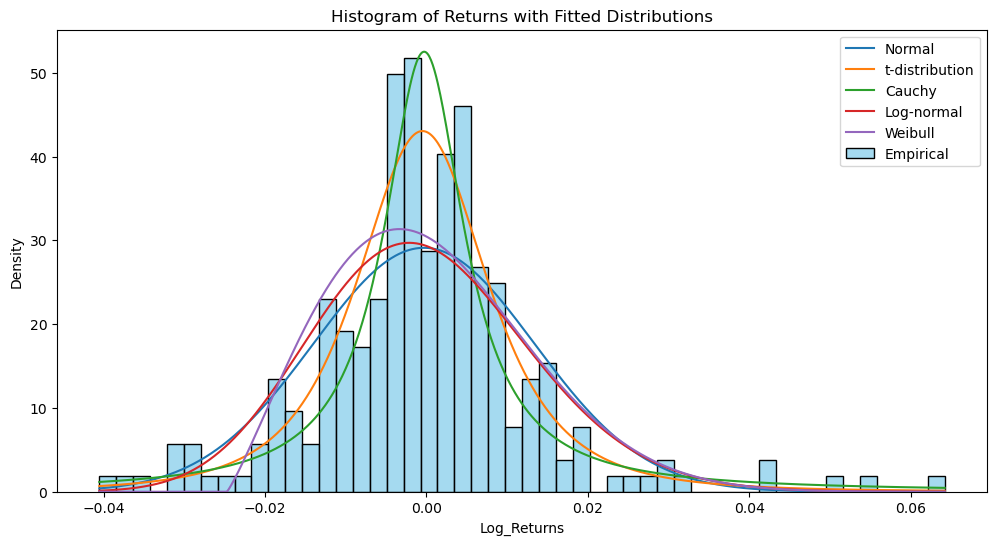

In [ ]:
x = np.linspace(returns.min(), returns.max(), 1000)
plt.figure(figsize=(12, 6))
sns.histplot(returns, bins=50, kde=False, stat='density', color='skyblue', label='Empirical')

for name, dist in distributions.items():
    y = dist.pdf(x, *params[name])
    plt.plot(x, y, label=name)

plt.title("Histogram of Returns with Fitted Distributions")
plt.legend()
plt.show()

## Hypothesis Testing using Kolmogorov-Smirnov Test

For each distribution:

- **H₀**: The stock returns follow this distribution.
- **H₁**: The stock returns do *not* follow this distribution.

We use the Kolmogorov–Smirnov test to evaluate goodness-of-fit and report p-values.

In [ ]:
ks_results = {}

print("Kolmogorov-Smirnov Test Results:")
print("-" * 50)
print(f"{'Distribution':<15}{'KS Statistic':<15}{'p-value':<15}")
print("-" * 50)

for name, dist in distributions.items():
    D, p_value = stats.kstest(returns, dist.cdf, args=params[name])
    ks_results[name] = (D, p_value)
    print(f"{name:<15}{D:<15.4f}{p_value:<15.4f}")

Kolmogorov-Smirnov Test Results:
--------------------------------------------------
Distribution   KS Statistic   p-value        
--------------------------------------------------
Normal         0.0974         0.0165         
t-distribution 0.0315         0.9591         
Cauchy         0.0501         0.5439         
Log-normal     0.0922         0.0271         
Weibull        0.0915         0.0289         


In [ ]:
# Sort by p-value in descending order
sorted_ks = sorted(ks_results.items(), key=lambda x: x[1][1], reverse=True)

# Print ranked results in a clean table format
print("Kolmogorov–Smirnov Test: Distribution Ranking by p-value")
print("-" * 50)
print(f"{'Rank':<5} {'Distribution':<15} {'KS Statistic':<15} {'p-value'}")
print("-" * 50)
for i, (name, (D_stat, p_val)) in enumerate(sorted_ks, 1):
    print(f"{i:<5} {name:<15} {D_stat:<15.4f} {p_val:.4f}")


Kolmogorov–Smirnov Test: Distribution Ranking by p-value
--------------------------------------------------
Rank  Distribution    KS Statistic    p-value
--------------------------------------------------
1     t-distribution  0.0315          0.9591
2     Cauchy          0.0501          0.5439
3     Weibull         0.0915          0.0289
4     Log-normal      0.0922          0.0271
5     Normal          0.0974          0.0165


## Additional Tests : Anderson-Darling & Jarque-Bera

In [ ]:
# Anderson–Darling Test
ad_stat = anderson(returns, dist='norm')
print("Anderson–Darling Test (Normal):")
print(f"{'Test Statistic:':<20} {ad_stat.statistic:.4f}")
print(f"{'Significance Level':<20} {'Critical Value':<20} {'Decision'}")
print("-" * 60)
for sl, cv in zip(ad_stat.significance_level, ad_stat.critical_values):
    decision = "Reject H₀" if ad_stat.statistic > cv else "Fail to Reject H₀"
    print(f"{str(sl)+'%':<20} {cv:<20.4f} {decision}")

Anderson–Darling Test (Normal):
Test Statistic:      3.9392
Significance Level   Critical Value       Decision
------------------------------------------------------------
15.0%                0.5670               Reject H₀
10.0%                0.6460               Reject H₀
5.0%                 0.7750               Reject H₀
2.5%                 0.9040               Reject H₀
1.0%                 1.0750               Reject H₀


In [ ]:
# Jarque–Bera Test
jb_stat, jb_p = jarque_bera(returns)
print("Jarque–Bera Test for Normality")
print(f"{'JB Statistic:':<15} {jb_stat:.4f}")
print(f"{'p-value:':<15} {jb_p:.4f}")
decision = 'Reject H₀' if jb_p < 0.05 else 'Fail to Reject H₀'
print(f"{'Decision:':<15} {decision}")

Jarque–Bera Test for Normality
JB Statistic:   164.0757
p-value:        0.0000
Decision:       Reject H₀


In [ ]:
from scipy.stats import skew, kurtosis
skew_val = skew(returns)
kurt_val = kurtosis(returns, fisher=False)  # Pearson definition (normal = 3)

print(f"Skewness: {skew_val:.4f}")
print(f"Kurtosis: {kurt_val:.4f}")

Skewness: 0.7274
Kurtosis: 6.7011


## 95% Confidence Interval for Mean Return

Based on the best-fitting distribution, we compute a 95% confidence interval for the mean return. Points outside this interval are flagged as statistically unusual.


95% CI for mean return (based on t-distribution): [-0.003208, 0.002575]
Number of outliers: 192


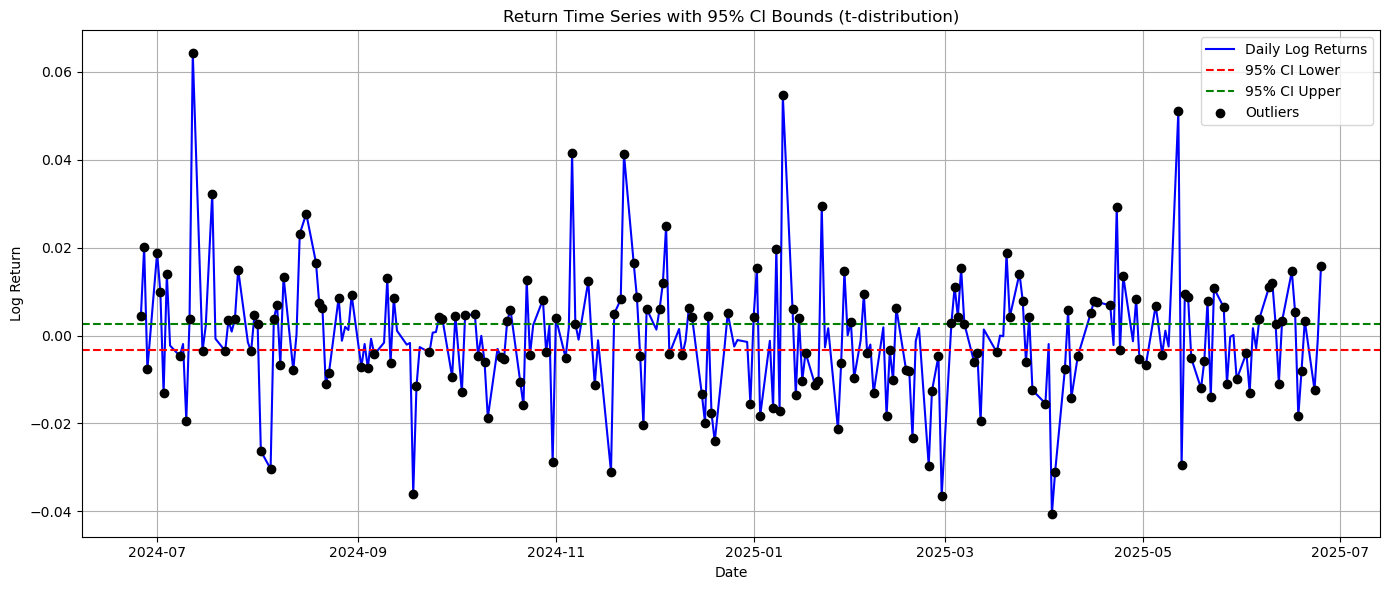

In [ ]:
# Use best-fitting distribution
best_fit_name = sorted_ks[0][0]
best_params = params[best_fit_name]

# 95% Confidence Interval for mean
mean_return = np.mean(returns)
sem = stats.sem(returns)
if best_fit_name == "t-distribution":
    df_t = best_params[0]
    ci_low, ci_high = stats.t.interval(0.95, df=df_t, loc=mean_return, scale=sem)
else:
    ci_low, ci_high = stats.norm.interval(0.95, loc=mean_return, scale=sem)

print(f"\n95% CI for mean return (based on {best_fit_name}): [{ci_low:.6f}, {ci_high:.6f}]")

# Outlier detection
outliers = data[(data['Log_Returns'] < ci_low) | (data['Log_Returns'] > ci_high)]
X = outliers.shape[0]
print(f"Number of outliers: {X}")

# Plot time series with CI bounds
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Log_Returns'], label='Daily Log Returns', color='blue')
plt.axhline(ci_low, color='red', linestyle='--', label='95% CI Lower')
plt.axhline(ci_high, color='green', linestyle='--', label='95% CI Upper')
plt.scatter(outliers.index, outliers['Log_Returns'], color='black', label='Outliers', zorder=5)
plt.title(f"Return Time Series with 95% CI Bounds ({best_fit_name})")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary

- **Best-fitting distribution:** Student's t (highest p-value in KS Test)
- **Confidence interval for mean return:** Computed using t-distribution
- **Number of outlier return days:** 192 (days outside 95% CI)
- **Goodness-of-fit tests:**
  - KS: Student’s t > Cauchy > Log-normal > Weibull > Normal
  - Anderson–Darling: Rejected normality
  - Jarque–Bera: Rejected normality (due to non-zero skewness and excess kurtosis)
- **Distributional stats:**
  - Skewness: 0.7274 (positive skew)
  - Kurtosis: 6.7011 (fat tails)